# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Feature Selection and Correlation Analysis](#correlations)


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
%pip install ucimlrepo


## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


### Attention: currently commented out since there is better way as shown in the next code snippet.

In [ ]:
# comment out the following lines


# change directory to the location of the dataset file CTG.xls

#%cd '/workspaces/Tensor-flow-project'

# Install xlrd package
#%pip install xlrd

# Replace 'your_dataset.csv' with the path to your actual dataset
#df = pd.read_excel('CTG.xls', sheet_name='Data')

# Number of samples
#num_samples = df.shape[0]

# Number of features
#num_features = df.shape[1]

# Display these dataset characteristics
#print(f"Number of samples: {num_samples}")
#print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
#print("Example data:")
#print(df.head())





### A more convenient option is to use the "fetch_ucirep" option.

In [ ]:
import pandas as pd

from ucimlrepo import fetch_ucirepo

# fetch dataset
df = fetch_ucirepo(id=193)

# data (as pandas dataframes)
X = df.data.features
y = df.data.targets

# metadata
print(df.metadata)

# variable information
print(df.variables)

#print number of samples and features
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")


# Display the first few rows of the dataframe to show the structure
print(f"Example data: {X.head()}")




## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [ ]:
# Check for missing values
missing_values_X = X.isnull().sum()
missing_values_y = y.isnull().sum()
missing_values_X
missing_values_y


## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


In [ ]:
# Example: Plotting histograms of all numerical features
X.hist(figsize=(12, 12))
plt.show()

y.hist(figsize=(4, 4))
plt.show()


## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


In [ ]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here

#check for class imbalance
sns.countplot(x='NSP', data=y) # clear imbalance in the classes





## Feature Selection and Correlation Analysis

[Explore correlations between features and the target variable, as well as among features themselves.]


### SelectKBest

SelectKBest is used to quickly identify the most relevant features based on their univariate relationship with the target variable. It is particularly helpful for initial feature screening because it ranks features by their statistical significance (e.g., using the ANOVA F-test).

In [ ]:
  # Example: Plotting a heatmap to show feature correlations
  correlation_matrix = X.corr()
  sns.heatmap(correlation_matrix, annot=True)
  plt.show()

  # results in unreadable plot due to large number of features
  # trying to reduce the number of features by selecting the most important ones

  ### Correlation of featurs with the target variable and feature selection

  # Feature selection
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  #apply SelectKBest class to extract top 10 best features --> highest discriminatory power
  bestfeatures = SelectKBest(score_func=f_classif, k=10)
  # Use the second column of y as the target variable, i.e. the NSP column
  fit = bestfeatures.fit(X, y.iloc[:, 1])
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(X.columns)

  #concat two dataframes for better visualization
  featureScores = pd.concat([dfcolumns, dfscores], axis=1)
  featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
  print(featureScores.nlargest(10, 'Score'))  #print 10 best features

  # Select the top 10 features
  X_selected = X[featureScores.nlargest(10, 'Score')['Specs']]
  # selected featurs with highest discriminatory power are : DP  ALTV ASTV  Mean  Mode  Median  AC  Variance  LB  MSTV



  ####  correlation of the selected features

  # Plot the heatmap of the top 10 features
  correlation_matrix = X_selected.corr()
  sns.heatmap(correlation_matrix, annot=True)

  # RESULT
  #  certainly better readability. only very few of the selected features are highly correlated (e.g. >0.8).
  # These are : Mean, Mode and Median -->  expecteable. We should use only one of them in the model.

  # Drop the Mode and Median columns form the selected features
  X_selected = X_selected.drop(['Mode', 'Median'], axis=1)












In [ ]:
# Plot the importance scores from SelectKBest
plt.figure(figsize=(10, 6))

# Sort the features by their scores in descending order
top_features = featureScores.nlargest(10, 'Score')

# Plot
plt.barh(top_features['Specs'], top_features['Score'])
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Top 10 Features by SelectKBest (f_classif)')
plt.gca().invert_yaxis()  # Wichtigste Features oben anzeigen
plt.show()


### Random Forest Feature Importance

Random Forest Feature Importance is added to account for feature interactions and non-linear relationships that SelectKBest might miss. Unlike univariate methods, Random Forest evaluates the role of each feature within the context of the entire dataset. This allows us to capture features that may not be individually significant but contribute strongly when combined with others.

Top 10 Features based on Random Forest Feature Importance:
   Feature  Importance
7     ASTV    0.133096
8     MSTV    0.130471
9     ALTV    0.121121
17    Mean    0.086454
16    Mode    0.061275
18  Median    0.056384
1       AC    0.048466
6       DP    0.048079
10    MLTV    0.043081
0       LB    0.038735


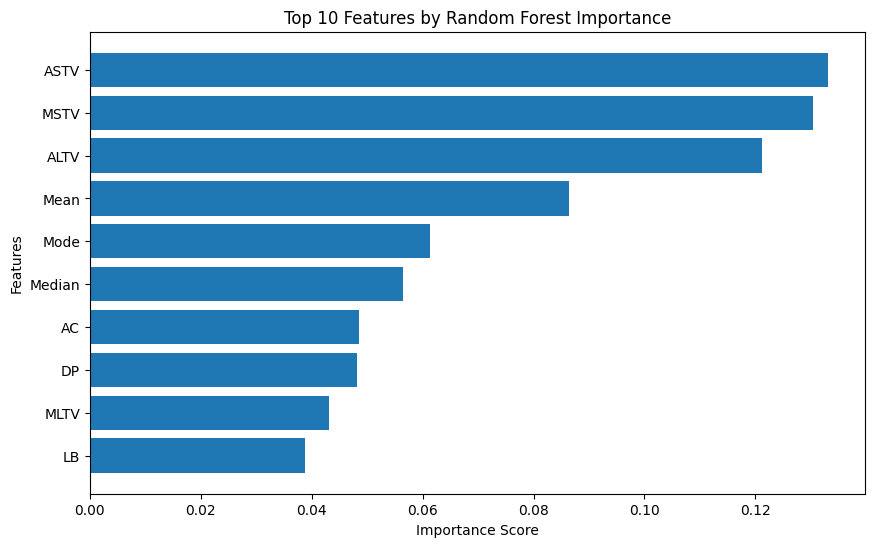

In [70]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Create 100 decision trees
rf.fit(X, y.iloc[:, 1])  # Target variable is the second column of y (NSP)

# Extract Feature Importances
importances = rf.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Features based on Random Forest Feature Importance:")
print(feature_importance_df.head(10))

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10))
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Features by Random Forest Importance')
plt.gca().invert_yaxis()  # Display the most important features at the top
plt.show()



#### Add MLTV to the list of selected features

In [ ]:
# Create a new DataFrame X_selected_9
X_selected_9 = X[featureScores.nlargest(10, 'Score')['Specs']]  # Top 10 features
X_selected_9 = X_selected_9.drop(['Mode', 'Median'], axis=1, errors='ignore')  # Drop Mode and Median if present

# Add MLTV explicitly
if 'MLTV' in X.columns:
    X_selected_9 = X_selected_9.assign(MLTV=X['MLTV'])
else:
    print("MLTV is not found in the original dataset.")


### Short description of the selected features

Based on the conducted analyses, the following features have been selected for further modeling and evaluation. These features were chosen using a combination of methods, including SelectKBest and Random Forest Feature Importance, to ensure the inclusion of both univariate significant features and those capturing complex interactions.

In [ ]:
# Define selected features, descriptions, and their data types
features_summary = {
    "DP": ["Prolonged decelerations", "Numerical"],
    "ALTV": ["Percentage of time with abnormal long-term variability", "Numerical"],
    "ASTV": ["Percentage of time with abnormal short-term variability", "Numerical"],
    "Mean": ["Histogram mean", "Numerical"],
    "AC": ["Accelerations (SisPorto)", "Numerical"],
    "Variance": ["Histogram variance", "Numerical"],
    "LB": ["Baseline value (SisPorto)", "Numerical"],
    "MSTV": ["Mean value of short-term variability (SisPorto)", "Numerical"],
    "MLTV": ["Mean value of long-term variability (SisPorto)", "Numerical"]  # Added MLTV
}

# Convert to a DataFrame for better readability
features_df = pd.DataFrame(
    [(key, value[0], value[1]) for key, value in features_summary.items()],
    columns=["Feature", "Description", "Data Type"]
)

# Set pandas display options to show full width of the table
pd.set_option('display.max_colwidth', None)  # Ensure descriptions are fully visible
pd.set_option('display.width', 1000)        # Set table width for better display

# Save or display the DataFrame
print(features_df)

### Distributions of the selected features

In [ ]:
# Extract full variable names from features_summary
feature_names = {key: value[0] for key, value in features_summary.items()}

# Plot histograms with full variable names
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid for 9 features
axes = axes.ravel()  # Flatten the axes for easy iteration

for idx, column in enumerate(X_selected_9.columns):  # Use X_selected_9 with 9 features
    ax = axes[idx]
    ax.hist(X_selected_9[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(feature_names[column], fontsize=10)  # Use full name as title
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Hide unused subplots if there are any (unlikely for 9 features in 3x3 grid)
for i in range(len(X_selected_9.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()





## Outlier

#### Outlier Detection

In this section, we analyzed outliers in the dataset using two statistical methods: the IQR (Interquartile Range) and Z-scores.

**IQR Method:**

We identified variables with symmetric distributions (e.g., Mean and LB) and calculated the lower and upper boundaries based on the IQR.
Boxplots were created to visualize these variables, marking the IQR boundaries with vertical dashed lines. Data points outside these boundaries were flagged as potential outliers.

**Z-Score Method:**

For variables with asymmetrical distributions (e.g., DP, ALTV, AC, Variance, MSTV, ASTV), Z-scores were calculated.
Scatter plots were used to visualize the Z-scores, with horizontal dashed lines marking thresholds at ±3. Data points exceeding these thresholds were considered potential outliers.
Both methods allow us to systematically identify and evaluate outliers, which can help improve the quality and reliability of further data analysis.

##### IQR method and Z-Score method

In [ ]:
# Function to detect outliers based on the IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)  # First quartile (25%)
    Q3 = data.quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile range (IQR)
    lower_bound = Q1 - 1.5 * IQR  # Lower boundary
    upper_bound = Q3 + 1.5 * IQR  # Upper boundary
    return lower_bound, upper_bound  # Return both boundaries


# Check for outliers in each feature using IQR
outlier_counts_iqr = X_selected_9.apply(detect_outliers_iqr)


# Calculate Z-scores for each feature
from scipy.stats import zscore
z_scores = zscore(X_selected_9, nan_policy='omit')  # Absolute Z-scores
z_scores_df = pd.DataFrame(z_scores, columns=X_selected_9.columns)  # Convert to DataFrame
outliers_zscore = (z_scores_df.abs() > 3).sum(axis=0)  # Count of outliers where Z > 3





In [ ]:
# Data: Number of outliers for each method
data = {
    "Feature": ["DP", "ALTV", "ASTV", "Mean", "AC", "Variance", "LB", "MSTV", "MLTV"],
    "Outliers (IQR)": [178, 309, 0, 45, 14, 184, 0, 70, 71],
    "Outliers (Z-Score)": [108, 59, 0, 26, 23, 44, 0, 33, 33],
    "Distribution": [
        "Highly skewed to the right",
        "Strongly skewed to the right",
        "Uniform distribution with peaks",
        "Symmetrical, approximately normal",
        "Strongly skewed to the right",
        "Highly skewed to the right",
        "Symmetrical and bell-shaped",
        "Right-skewed distribution",
        "Moderately skewed to the right"  #
    ]
}

# Create a DataFrame
outlier_summary = pd.DataFrame(data)

# Display the DataFrame
print(outlier_summary)


##### Visualisation of outliers

In [ ]:
# Variables with symmetric distributions suitable for IQR
suitable_for_iqr = ["Mean", "LB", "MLTV"]  # MLTV hinzugefügt

# Create subplots
fig, axes = plt.subplots(1, len(suitable_for_iqr), figsize=(15, 5))  # Adjust layout

# Iterate over the columns and create a boxplot for each
for idx, column in enumerate(suitable_for_iqr):
    ax = axes[idx]  # Current axis
    lower_bound, upper_bound = detect_outliers_iqr(X_selected_9[column])  # Calculate IQR boundaries

    # Boxplot on the current axis
    sns.boxplot(
        x=X_selected_9[column],
        color="skyblue",
        showmeans=True,
        meanprops={"marker": "D", "markerfacecolor": "green", "markeredgecolor": "black"},
        ax=ax
    )

    # Mark the IQR boundaries with vertical lines
    ax.axvline(lower_bound, color="red", linestyle="--", label="Lower Boundary (IQR)")
    ax.axvline(upper_bound, color="green", linestyle="--", label="Upper Boundary (IQR)")

    # Set title and labels
    ax.set_title(f"{column} (IQR)")
    ax.set_xlabel("Value")
    ax.set_ylabel("")  # No y-axis label needed

    # Add legend only to the first plot
    if idx == 0:
        ax.scatter([], [], color="green", marker="D", label="Mean")  # Dummy point for legend
        ax.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()



In [ ]:
from scipy.stats import zscore

# Calculate Z-scores and convert to a DataFrame
z_scores = zscore(X_selected, nan_policy='omit')  # Z-scores as a NumPy array
z_scores_df = pd.DataFrame(z_scores, columns=X_selected.columns)  # Convert to DataFrame

# Variables with asymmetrical distribution
asymmetrical_features = ["DP", "ALTV", "AC", "Variance", "MSTV", "ASTV"]

# Create subplots
fig, axes = plt.subplots(1, len(asymmetrical_features), figsize=(20, 5))  # Wider layout for multiple plots

for idx, column in enumerate(asymmetrical_features):
    ax = axes[idx]  # Current axis
    feature_z_scores = z_scores_df[column]  # Z-scores for the current variable

    # Scatter plot for Z-scores
    ax.scatter(range(len(feature_z_scores)), feature_z_scores, alpha=0.5, label="Data Points")

    # Horizontal lines for Z-score thresholds
    ax.axhline(3, color="red", linestyle="--", label="Z = +3 (Upper Limit)")
    ax.axhline(-3, color="red", linestyle="--", label="Z = -3 (Lower Limit)")

    # Set title and labels
    ax.set_title(f"{column} (Z-Score)")
    ax.set_xlabel("Index")
    ax.set_ylabel("Z-Score")

    # Display legend only in the first plot
    if idx == 0:
        ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
